# Time Series Analysis of the Standard and Poor's (S&P) 500 Index

#### Daphka Alius
#### April 15, 2019

Time Series are a sequence of observations taken at discrete intervals in time. Time series are worth investigated due to the powerful insights they provide in forecasting and predicting future observations. This project will employ different statistical tools, such as statsmodels, to forecast the 2018 yearly returns of the S&P 500 Index. Time series analysis has been one of many tools used to analyze stocks and model returns.

The Standard and Poor's 500 Index, commonly known as the S&P 500 Index, is an American Stock Market index based on the market capitalization of the 500 largest publicly traded companies in the US (Investopedia). The breakdown of the index by sector is extremely diverse with bigger weights in sectors such as Information Technology, Communication Services, Health (Dow Jones). The 10 largest companies with highest weights include household names like Apple, Amazon, Berkshire Hathaway, Facebook, and Alphabet(Google). The S&P 500 Index is commonly used by investors as a benchmark for returns since it captures so much of the market returns and therefore can be used examine the health of the United States economy.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import thinkplot
import thinkstats2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [21]:
path = "/Users/daphka/Desktop/^GSPC.csv"

## Loading Data

Reading the CSV file into a Pandas DataFrame and converting the Date column into a datetime object.

In [22]:
SP500 = pd.read_csv(path, parse_dates =[0], index_col=0)

The columns of the data set are:

+ **Open:** The price of a stock at opening
+ **High:** Highest recorded trading price of the day
+ **Low:** Lowest recorded trading price of the day
+ **Adj Close:** Amended closing price of the day
+ **Volume:** Number of stocks traded on this day

The data is the monthly return of the S&P500 dating from 1/1/1997 to 12/1/2018.

In [23]:
SP500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-01-01,740.739990,794.669983,729.549988,786.159973,786.159973,11635830000
1997-02-01,786.159973,817.679993,773.429993,790.820007,790.820007,9715930000
1997-03-01,790.820007,814.900024,756.130005,757.119995,757.119995,10120760000
1997-04-01,757.119995,804.130005,733.539978,801.340027,801.340027,10454880000
1997-05-01,801.340027,851.869995,793.210022,848.280029,848.280029,10106650000


In [24]:
SP500.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-01,2821.169922,2916.500000,2796.340088,2901.520020,2901.520020,69238220000
2018-09-01,2896.959961,2940.909912,2864.120117,2913.979980,2913.979980,62492080000
2018-10-01,2926.290039,2939.860107,2603.540039,2711.739990,2711.739990,91327930000
2018-11-01,2717.580078,2815.149902,2631.090088,2760.169922,2760.169922,80080110000
2018-12-01,2790.500000,2800.179932,2346.580078,2506.850098,2506.850098,83519570000


Here's a the preliminary statistics summary of the variables.

In [25]:
SP500.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,264.0,1.444534e+03,5.012407e+02,7.295700e+02,1.110695e+03,1.302360e+03,1.615263e+03,2.926290e+03
High,264.0,1.489961e+03,5.060851e+02,7.946700e+02,1.146042e+03,1.342175e+03,1.690080e+03,2.940910e+03
Low,264.0,1.394649e+03,4.927820e+02,6.667900e+02,1.074600e+03,1.257845e+03,1.587103e+03,2.864120e+03
Close,264.0,1.450407e+03,5.021138e+02,7.350900e+02,1.111878e+03,1.302830e+03,1.631297e+03,2.913980e+03
Adj Close,264.0,1.450407e+03,5.021138e+02,7.350900e+02,1.111878e+03,1.302830e+03,1.631297e+03,2.913980e+03
Volume,264.0,5.753797e+10,3.251090e+10,9.715930e+09,2.737350e+10,6.408518e+10,7.970272e+10,1.618436e+11


## Variable of Interest: Adj Close

Adj Close is short for adjusted closing price. The adjusted closing price of the index refers to the closing price of the stock amended to any corporate actions that may have influenced the stock price for that day.

I will be using data from 1/1/1997-12/31/2017 to extract information to build a model to forecast the 2018 monthly returns.

In [26]:
prices = SP500["Adj Close"][:-12]

In [27]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.set_style("dark")



Here's a plot of the adjusted closing price over the past 20 years.

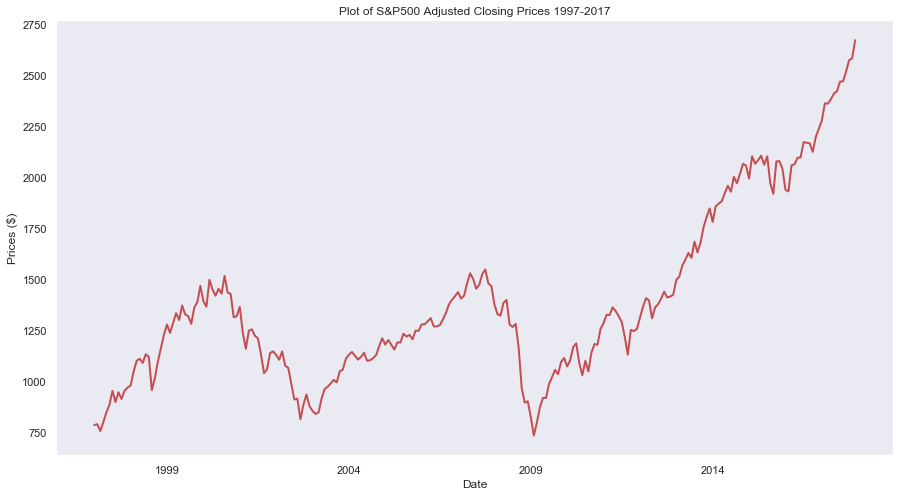

In [28]:
prices.plot(linewidth=2, c="r");
plt.ylabel('Prices ($)')
plt.title('Plot of S&P500 Adjusted Closing Prices 1997-2017')
plt.savefig("adjclose.png", bbox_inches="tight", ext="png")
plt.show()

Any time series analysis is based on the modeling assumption that the observations have the following three components:
1. Trend - captures long-term changes
2. Seasonality - captures periodic variations in the data
3. Noise - random variation of the trend

The existence of these components determine whether the data is stationary or non-stationary. A data is considered **stationary** if the observations for all time *t* is from the same distribution. In other words, a time series is stationary if the mean, variance, and correlation are the same for all observations.

## Exploratory Analysis

### Motivating Question: Is the adjusted closing price of the S&P500 stationary over the 20 years period?

In order to determine if the data is stationary or non-stationary, we have to see if there's any trend or seasonality.

**Trend:** Based on the plot, it seems that the  adjusted closing price has been increasing over the past 20 years. However, we can use a rolling mean to smoothen out this pattern. A rolling mean is a statistical tool used to smoothen short-term fluctuations in the data set in order to highlight long-term trends.

#### Testing for trend using a rolling mean

Here I used a rolling mean with a window size = 12 to capture yearly data. I've also calculated the rolling standard deviation to see if there's any volatility.

In [29]:
rollingMean = prices.rolling(12).mean()
rollingStd = prices.rolling(12).std()

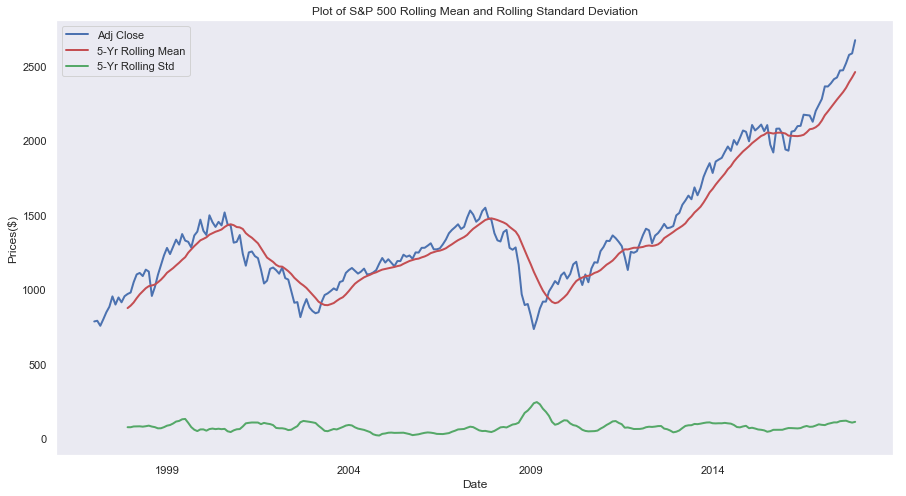

In [33]:
prices.plot(linewidth=2)
rollingMean.plot(label = "5-Yr Rolling Mean", linewidth=2, c="r")
rollingStd.plot(label = "5-Yr Rolling Std", linewidth=2, c="g")
plt.ylabel("Prices($)")
plt.title("Plot of S&P 500 Rolling Mean and Rolling Standard Deviation")
plt.legend()
plt.savefig("rollingmean.png", bbox_inches="tight", ext="png")
plt.show()

The rolling mean smoothen some of the volatility of the stock market and visibly depict an upward trend that confirms the increasing pattern of the S&P500 Index. Additionally, the rolling standard deviation shows some variation in standard deviation which is a sign that this variable may not but stationary.

#### Can summary statistics tell us more?

Another method to test stationary is to look at the summary statistics.

Here I partition the data into 4 sets of equal width and compute the summary statistics like mean and variance to see if the data is consistent through out each partition.

In [34]:
split = int(len(prices)/4)
part1, part2, part3, part4 = prices.values[:split], prices.values[split: 2*split], prices.values[2*split: 3*split], prices.values[3*split:]

In [35]:
mean1, mean2, mean3, mean4 = part1.mean(), part2.mean(), part3.mean(), part4.mean()
var1, var2, var3, var4 = part1.var(), part2.var(), part3.var(), part4.var()
df_stats = pd.DataFrame()
df_stats["Mean"] = [mean1, mean2, mean3, mean4]
df_stats["Variance"] = [var1, var2, var3, var4]

In [37]:
df_stats.transpose()

,0,1,2,3
Mean,1177.487296,1155.503010,1210.167297,2013.139210
Variance,39473.506248,31220.151783,37376.975132,90295.487442


This results of this procedure show that the mean and variance is not consistent across all partition, which is another sign that this data set is non-stationary. However, this method may not be as meaningful since the data does not come from a normal distribution which is an assumption of this method. Nonetheless, based on the plot, we will continue to assume that this data is **non-stationary**.

#### Using statsmodels time series module to decompose the dataset

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

statsmodels provide a method called **seasonal_decompose** which breaks down your time series into its three components:
1. Trend
2. Seasonality
3. Noise

In [39]:
decomposition = seasonal_decompose(prices)

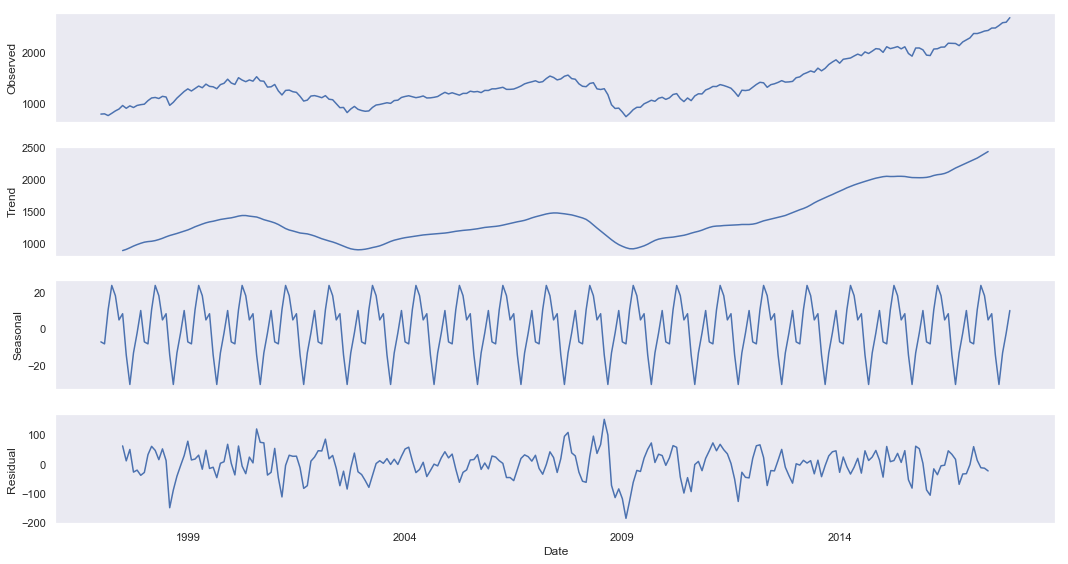

In [41]:
fig = decomposition.plot()
plt.savefig("decomposition.png", bbox_inches="tight", ext="png")

This decomposition provides a holistic breakdown of our variable which not only has a **trend** but also some **seasonality**. These tools both graphically and statistically provided a preliminary test of stationary using basic tools and the components of the data set. However, there is an even more robust test of stationarity called the Augmented Dickey-Fuller Test.

### Augmented Dickey-Fuller Test for Stationarity

Simplistically, the Augmented Dickey-Fuller Test for Stationarity is a statistical test known as a unit root test. A unit root test defines how strongly a time series is defined by its trend. The null hypothesis is that a time series can be represented by a unit root, which would imply that the variable is non-stationary. The alternate hypothesis in this case would be the negation - that it is stationary. Therefore, if we find a large p-value from this test, then we can determine that our variable is non-stationary and a smaller p-value would indicate stationary.

In [48]:
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.statespace.tools import diff

In [49]:
adf_result = adfuller(prices)

In [50]:
adf_result

(0.8076504166249344,
 0.9917586617863505,
 0,
 251,
 {'1%': -3.4566744514553016,
  '5%': -2.8731248767783426,
  '10%': -2.5729436702592023},
 2547.6426486357336)

In [51]:
print("ADF Statistics: {}, p-value: {}".format(adf_result[0], adf_result[1]))
for key, value in adf_result[4].items():
    print(key, value)

ADF Statistics: 0.8076504166249344, p-value: 0.9917586617863505
1% -3.4566744514553016
5% -2.8731248767783426
10% -2.5729436702592023


Based on the results of the ADF, we can see that our p-value is really high which would support the null hypothesis that this time series does have a unit root which would imply that is it is indeed **non-stationary**.

## Estimating a Model for Forecasting

We've been looking at trend and seasonality to determine whether our data is stationary or not, we can also look at the correlation between the observations to see if it constant. 

In order to build a model for forecasting, it is crucial to know how much to transform and adjust our variable in order to make it stationary. This is why we will use the Autocorrelation function to see how much differencing we need to transform the data to stationary.

### Autocorrelation Function (ACF)

Recall that time Series data have the property that they are ordered which means that past values can help us predict future values based on the correlation between each observations. The Autocorrelation Function (ACF) plots the coefficients of correlation between a time series and lags of itself. In simpler terms, the *ACF* provides insights on how points in the data are correlated separated by a specific lag time. A **lag** is an interval used to calculate the correlation. For example, when lag = 1, we are calculating the correlation between values at *t=0* with *t=1*, *t=1* and *t=2*, *...*, and *t=n-1* and *t=n*.

### Using the statsmodels plot_acf module to plot the ACF

This model works under the following assumptions:
1. lag = 40 and 
2. alpha = 0.05, which means that it plots the 95% confidence interval.

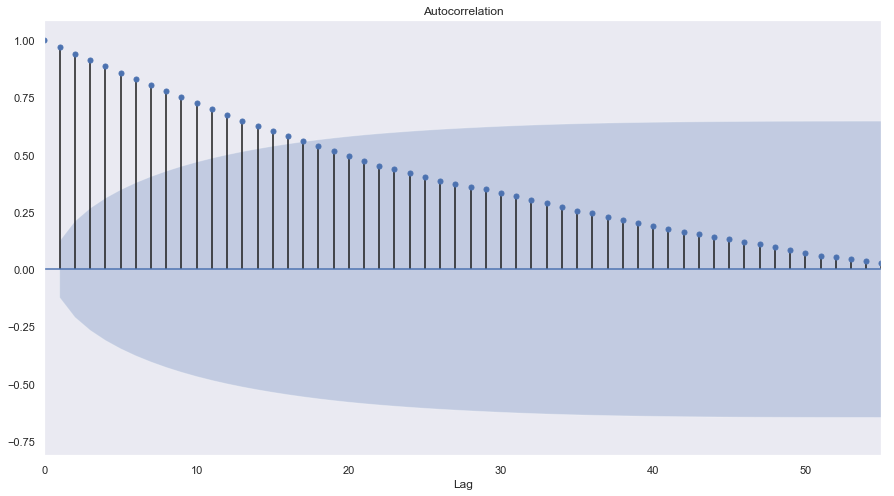

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(prices)
plt.xlabel("Lag")
plt.xlim(0, 55)
plt.savefig("acf1.png", bbox_inches="tight", ext="png")
plt.show()


As is expected, we see that our correlation is not constant across different lags since we have shown that this variable is non-stationary. 

### Transforming Data into Stationary by Taking the Differences

This function transforms the data using a lag of order 1 (d = 1) by default, which means that it computes the autocorrelation of one value with the consecutive value.

In [53]:
prices_diff = diff(prices)

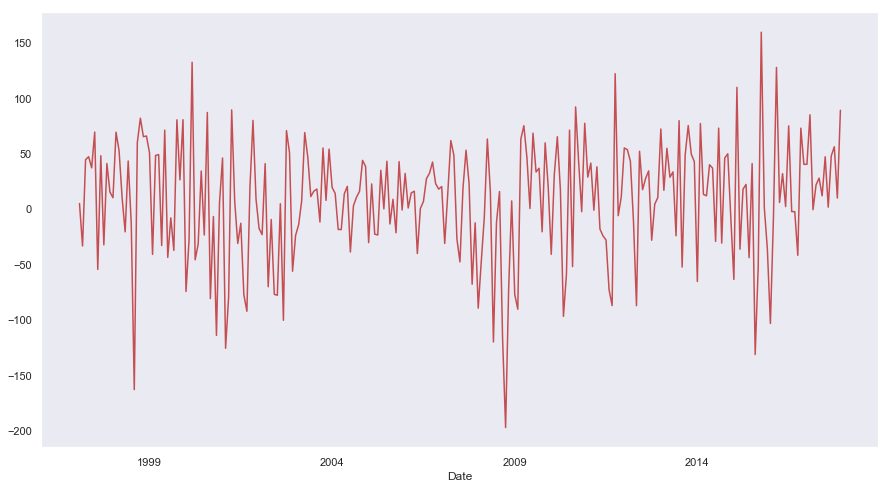

In [54]:
prices_diff.plot(c="r")
plt.savefig("transformed_adjclose.png", bbox_inches="tight", ext="png")
plt.show()

Now, I will plot this transformed variable using the plot_acf function of statsmodels

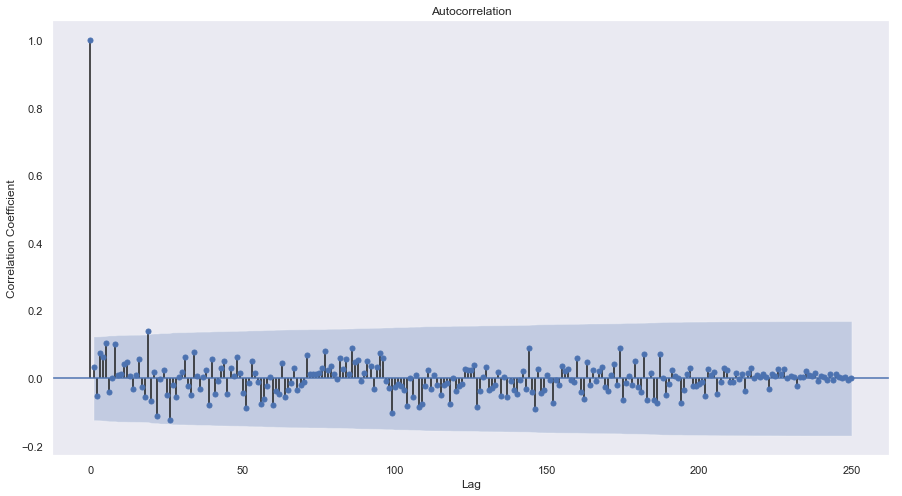

In [56]:
plot_acf(prices_diff)
plt.xlabel("Lag")
plt.ylabel("Correlation Coefficient")
plt.savefig("transformed_acf", bbox_inches="tight", ext="png")
plt.show()

In [57]:
adf_result_diff = adfuller(prices_diff)

In [58]:
print("ADF Statistics for Prices Diff: {}, p-value: {}".format(adf_result_diff[0], adf_result_diff[1]))
for key, value in adf_result_diff[4].items():
    print(key, value)

ADF Statistics for Prices Diff: -15.155031303806982, p-value: 6.7134196574358405e-28
1% -3.456780859712
5% -2.8731715065600003
10% -2.572968544


Observe that the value of the adf test is strongly negative and the p-value is significantly smaller than before which means we can assume that our model has been transformed from non-stationary to stationary. Now we will employ the ARIMA model to forecast the next years adjusted return prices.

**ARIMA MODEL**

EXPLAINS PHILOSOPHY OF ARIMA MODEL

In [59]:
from statsmodels.tsa.arima_model import ARIMA

In [60]:
arima_results = ARIMA(prices, order=(1, 1, 0))

/Users/daphka/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/daphka/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [61]:
model_fit = arima_results.fit()

/Users/daphka/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/daphka/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/daphka/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

In [62]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  251
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1355.005
Method:                       css-mle   S.D. of innovations             53.489
Date:                Sun, 07 Apr 2019   AIC                           2716.009
Time:                        15:47:30   BIC                           2726.585
Sample:                    02-01-1997   HQIC                          2720.265
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.5305      3.493      2.156      0.032       0.684      14.377
ar.L1.D.Adj Close     0.0336      0.063      0.531      0.596      -0.090       0.158
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           29.7600           +0.0000j           29.7600            0.0000
-----------------------------------------------------------------------------
"""

In [63]:
resid = model_fit.resid

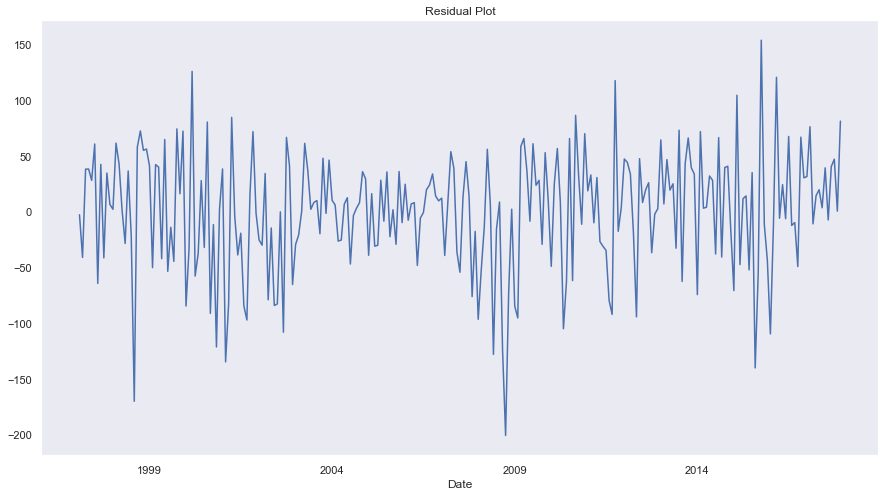

In [65]:
resid.plot()
plt.title("Residual Plot")
plt.savefig("residuals.png", bbox_inches="tight", ext="png")
plt.show()

In [66]:
resid.describe()

count    251.000000
mean       0.000463
std       53.596278
min     -200.973792
25%      -31.128287
50%        5.399341
75%       36.808593
max      153.804979
dtype: float64

In [67]:
from thinkstats2 import Cdf

In [68]:
resid_cdf = Cdf(resid)

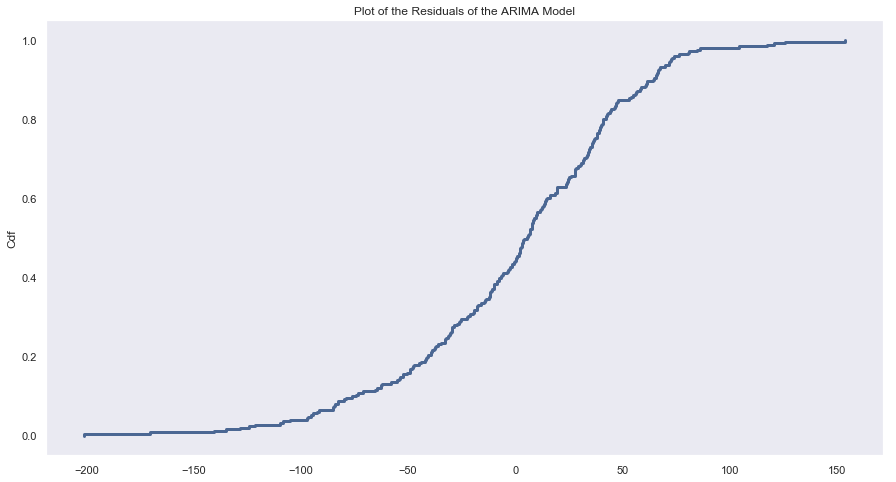

In [70]:
thinkplot.Cdf(resid_cdf)
plt.ylabel("Cdf")
plt.title("Plot of the Residuals of the ARIMA Model")
plt.savefig("residual_cdf.png", bbox_inches="tight", ext="png")
plt.show()

Based on the Cumulative Distribution Function plot of the residuals, it can be seen that they follow a normal distribution with mean 0, which confirms that our model is a great fit. Now that we have found a fitting model, we can continue to forecast the stock prices of 2018.

In [71]:
result = model_fit.forecast(steps=12)

In [72]:
result

(array([2683.87043044, 2691.49265502, 2699.02623366, 2706.55683361,
        2714.08733346, 2721.61782994, 2729.14832632, 2736.67882269,
        2744.20931906, 2751.73981543, 2759.2703118 , 2766.80080817]),
 array([ 53.48940549,  76.92686887,  94.76841025, 109.74782302,
        122.91511413, 134.80232253, 145.72304913, 155.88055663,
        165.41550357, 174.43001379, 183.00101256, 191.18815728]),
 array([[2579.03312213, 2788.70773876],
        [2540.71876259, 2842.26654746],
        [2513.2835627 , 2884.76890463],
        [2491.4550531 , 2921.65861411],
        [2473.1781366 , 2954.99653031],
        [2457.41013274, 2985.82552714],
        [2443.53639831, 3014.76025433],
        [2431.15854581, 3042.19909957],
        [2420.00088957, 3068.41774855],
        [2409.86327059, 3093.61636027],
        [2400.59491806, 3117.94570555],
        [2392.07890563, 3141.52271071]]))

In [73]:
time_2018 = pd.date_range(start="1/1/2018", end="12/31/2018", freq="MS")

In [74]:
prices_2 = prices.copy()

In [75]:
prices_2.tail()

Date
2017-08-01    2471.649902
2017-09-01    2519.360107
2017-10-01    2575.260010
2017-11-01    2584.840088
2017-12-01    2673.610107
Name: Adj Close, dtype: float64

In [76]:
i=0
for date in time_2018:
    prices_2[date] = result[0][i]
    i+=1


In [77]:
prices_2.tail()

Date
2018-08-01    2736.678823
2018-09-01    2744.209319
2018-10-01    2751.739815
2018-11-01    2759.270312
2018-12-01    2766.800808
Name: Adj Close, dtype: float64

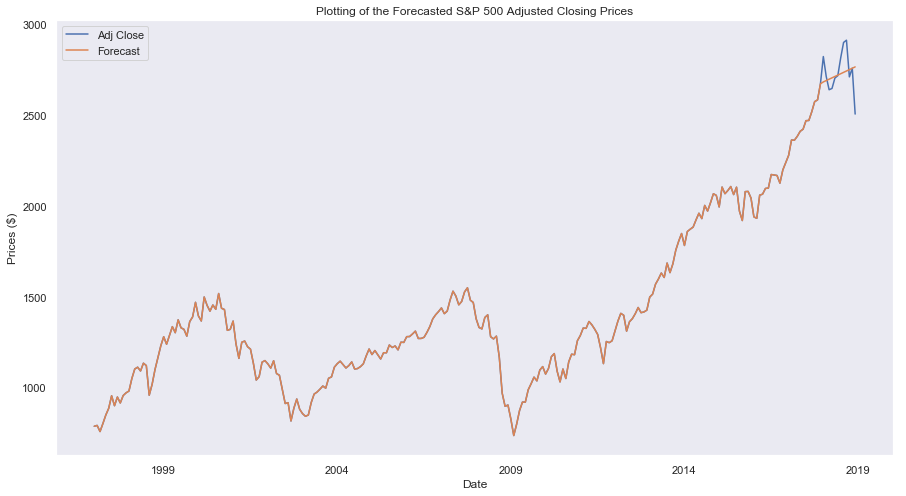

In [79]:
SP500["Adj Close"].plot()
prices_2.plot(label="Forecast")
plt.title("Plotting of the Forecasted S&P 500 Adjusted Closing Prices")
plt.ylabel("Prices ($)")
plt.legend()
plt.savefig("forecast.png", bbox_inches="tight", ext="png")
plt.show()

In [83]:
result_df = pd.DataFrame()
result_df["EXPECTED"] = SP500["Adj Close"][-12:]
result_df["FORECAST"] = prices_2[-12:]

result_df

,EXPECTED,FORECAST
Date,,
2018-01-01,2823.810059,2683.870430
2018-02-01,2713.830078,2691.492655
2018-03-01,2640.870117,2699.026234
2018-04-01,2648.050049,2706.556834
2018-05-01,2705.270020,2714.087333
2018-06-01,2718.370117,2721.617830
2018-07-01,2816.290039,2729.148326
2018-08-01,2901.520020,2736.678823
2018-09-01,2913.979980,2744.209319


In [84]:
from sklearn.metrics import mean_squared_error

In [85]:
print("MSE",mean_squared_error(SP500["Adj Close"][-12:], prices_2[-12:]))

MSE 13311.589441622107


**NOTE: Need to interpret results of forecast and conclude. Also add references. **

# EXTRA

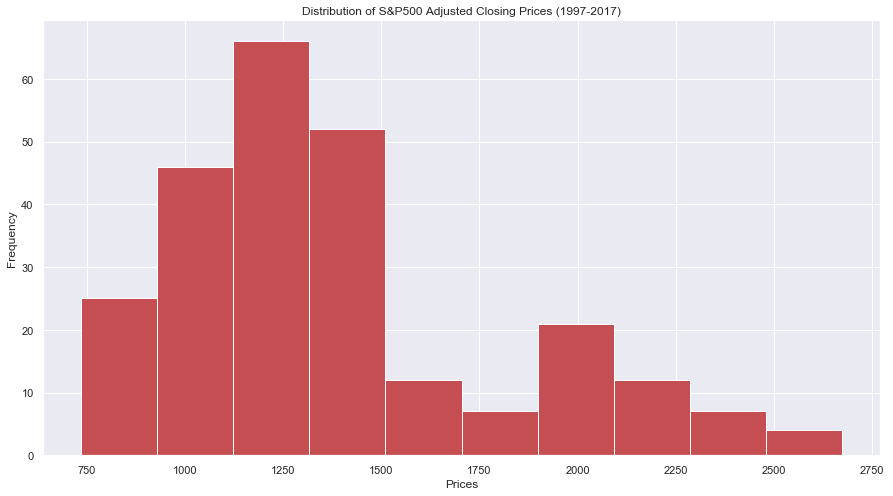

In [16]:
prices.hist(color="r")
plt.title("Distribution of S&P500 Adjusted Closing Prices (1997-2017)")
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.show()


In [27]:
acf_results = acf(prices, qstat=True, alpha=0.05)
pacf_results = pacf(prices, alpha=0.05)

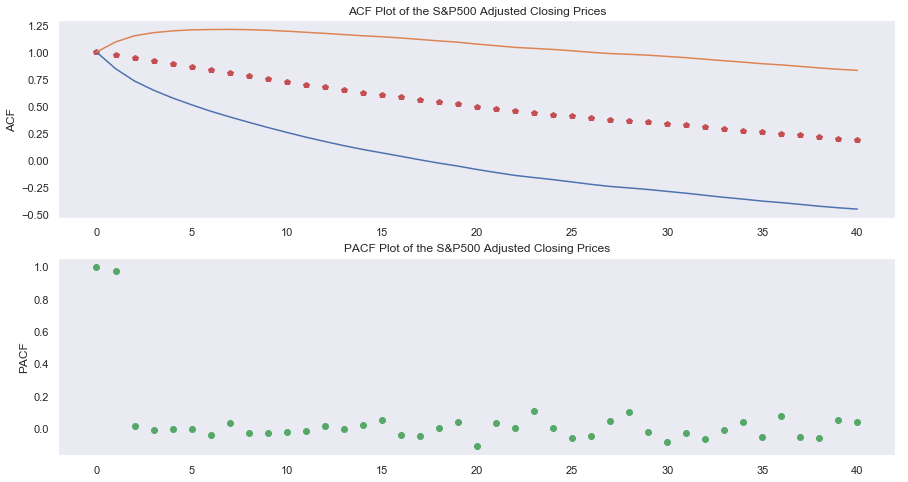

In [28]:
plt.subplot(2,1, 1)
plt.plot(acf_results[0], "p", c="r")
plt.ylabel("ACF")
plt.title("ACF Plot of the S&P500 Adjusted Closing Prices")
plt.plot(acf_results[1])




plt.subplot(2, 1, 2)
plt.plot(pacf_results[0], "o", c="g")
plt.title("PACF Plot of the S&P500 Adjusted Closing Prices")
plt.ylabel("PACF")
plt.show()

/Users/daphka/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


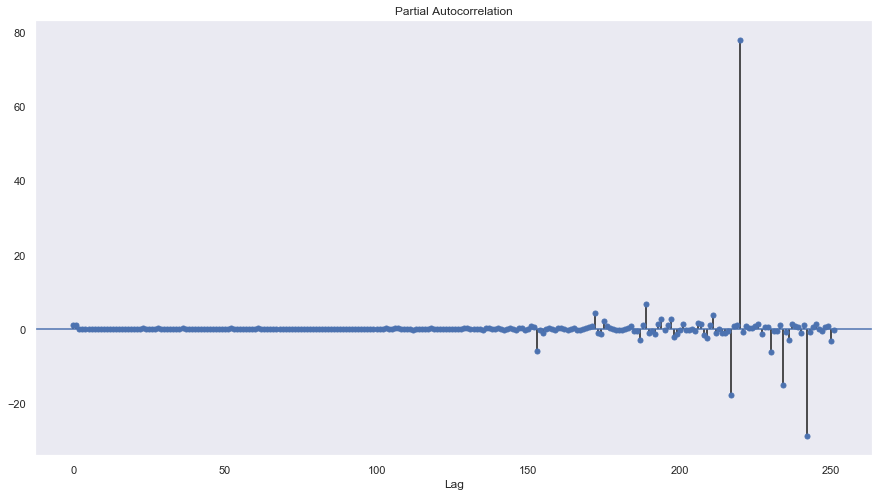

In [30]:
plot_pacf(prices)
plt.xlabel("Lag")
plt.show()

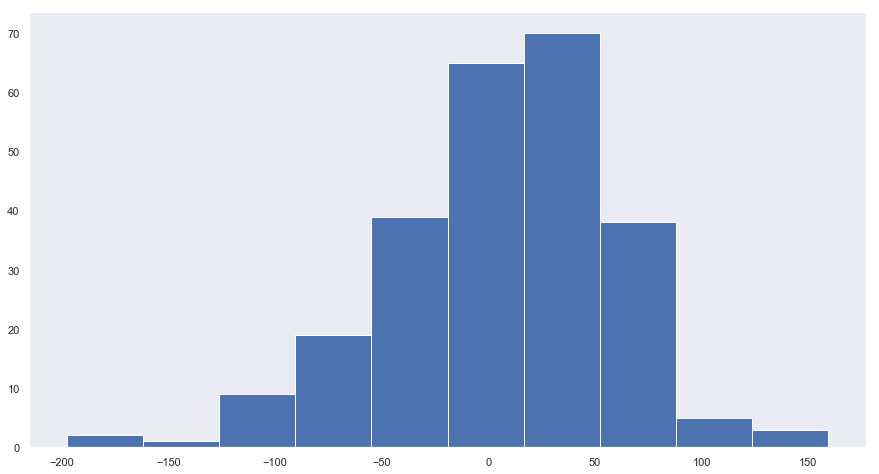

In [33]:
plt.hist(prices_diff)
plt.show()

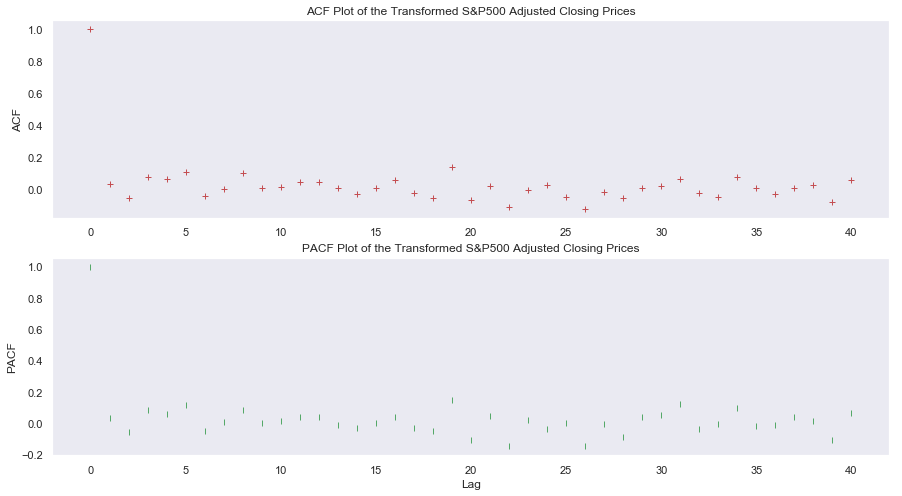

In [34]:
acf_results_diff = acf(prices_diff)
pacf_results_diff = pacf(prices_diff)

plt.subplot(2,1, 1)
plt.plot(acf_results_diff, "+", c="r")
plt.ylabel("ACF")
plt.title("ACF Plot of the Transformed S&P500 Adjusted Closing Prices")
plt.subplot(2, 1, 2)
plt.plot(pacf_results_diff, "|", c="g")
plt.title("PACF Plot of the Transformed S&P500 Adjusted Closing Prices")
plt.ylabel("PACF")
plt.xlabel("Lag")
plt.show()

In [ ]:
plot_pacf(prices_diff)
plt.xlabel("Lag")
plt.ylabel("Correlation Coefficient")
plt.show()